In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [7]:
anesthetic_agent_list = [('anesthesiaLvrOdd', 'dexmedetomidine')]
cfg.plotting.anesthetic_agent_list = anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [8]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [ ]:
from sklearn.model_selection import cross_val_score
top_percent = 0.1

lever_window = 120
analysis_window = 15

data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
session_lists = agent_data[('anesthesiaLvrOdd', 'dexmedetomidine')]['session_lists']

single_session_tracking_data = {}

pct_correct_thresh_options = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


iterator = tqdm(total=(len(session_lists['SPOCK']['high']) + len(session_lists['PEDRI']['high']))*len(pct_correct_thresh_options))

for pct_correct_thresh in pct_correct_thresh_options:
    single_session_tracking_data[pct_correct_thresh] = {}
    for monkey in ['SPOCK', 'PEDRI']:
        single_session_tracking_data[pct_correct_thresh][monkey] = {}
        for session in session_lists[monkey]['high']:
            cfg.params.data_class = data_class
            delase_results = agent_data[(data_class, agent)]['delase_results']

            area = 'all'

            if 'propofol' in cfg.params.data_class:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f'{session}.mat'), 'r')
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f'{session}.mat'), 'r')

            freq_band_to_plot = 'None'

            if 'propofol' not in cfg.params.data_class:
                infusion_start = session_file['sessionInfo']['infusionStart'][0, -1]
            else:
                infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
            stab_means = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean())
            stab_sems = delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].std()/np.sqrt(len(x[:int(top_percent*len(x))])))
            time_vals = (delase_results[session][area].window_start - infusion_start)/60

            if 'propofol' not in cfg.params.data_class:
                pct_correct, pct_correct_windows = get_pct_correct(cfg, session_file, lever_window=120, stride=15)
                high_perf_times = (pct_correct_windows - infusion_start)/60
                # high_perf_mask = (pct_correct > pct_correct_thresh) | (pct_correct_windows <= infusion_start)
                high_perf_mask = (pct_correct > pct_correct_thresh)

           
            perf_start_times = np.array([int(np.round(t)) for t in pct_correct_windows + 60])
            stab_start_times = np.array([int(np.round(t)) for t in (time_vals*60 + infusion_start).to_numpy()])
            time_bool1 = np.array([t in stab_start_times for t in perf_start_times])
            time_bool2 = np.array([t in perf_start_times for t in stab_start_times])
            stab_means = stab_means[time_bool2]
            stab_sems = stab_sems[time_bool2]
            time_vals = time_vals[time_bool2]
            high_perf_mask = high_perf_mask[time_bool1]
            stab_start_times = stab_start_times[time_bool2]
            perf_start_times = perf_start_times[time_bool1]
            high_perf_times = high_perf_times[time_bool1]

            single_session_tracking_data[pct_correct_thresh][monkey][session] = {
                'time_vals': time_vals,
                'stab_means': stab_means,
                'stab_sems': stab_sems,
                'high_perf_times': high_perf_times,
                'high_perf_mask': high_perf_mask,
                'awake_stab_means': stab_means[high_perf_mask].mean(),
                'unconscious_stab_means': stab_means[~high_perf_mask].mean()
            }

            iterator.update(1)
iterator.close()


  0%|          | 0/144 [00:00<?, ?it/s]

monkey: SPOCK, p: 0.00390625


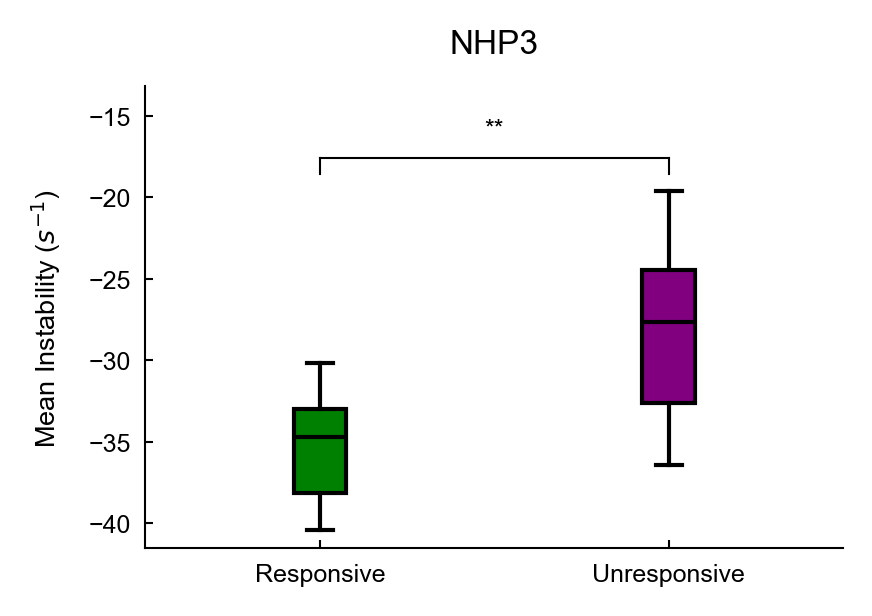

monkey: PEDRI, p: 0.00390625


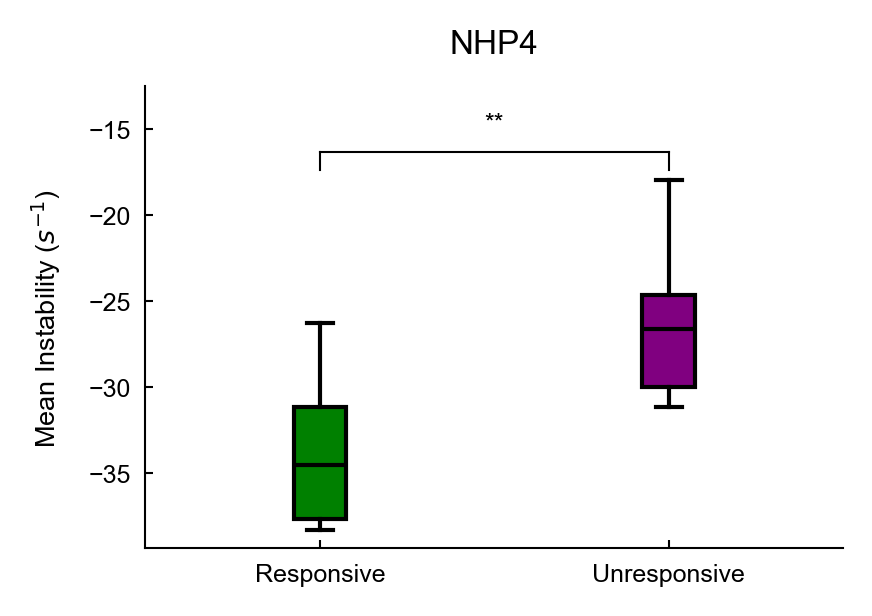

In [10]:
# Add these imports at the top of your notebook if not already present
from scipy.stats import wilcoxon
import numpy as np

pct_correct_thresh = 0.1

# Then modify your plotting code to include the statistical testing
for i,monkey in enumerate(['SPOCK', 'PEDRI']):
    awake_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['awake_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
    unconscious_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['unconscious_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
    # Data for plotting
    labels = ['Responsive', 'Unresponsive']
    stab_means_all = [awake_stab_means_all, unconscious_stab_means_all]

    # Perform Mann-Whitney U test
    stat, p = wilcoxon(awake_stab_means_all, unconscious_stab_means_all, alternative='less')
    print(f"monkey: {monkey}, p: {p}")
    
    fig, ax = plt.subplots(figsize=(3, 2))
    bp = ax.boxplot(stab_means_all, tick_labels=labels,
                    medianprops=dict(color='black'),
                    patch_artist=True, showfliers=False)  # This enables filling of the boxes

    # Set colors for each box
    colors = ['green', 'purple']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add significance bar
    y_max = max([max(data) for data in stab_means_all])
    y_min = min([min(data) for data in stab_means_all])
    y_range = y_max - y_min
    
    # Calculate significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    
    # Add significance bar with stars
    x1, x2 = 1, 2  # positions of the two groups
    y_bar_max = y_max
    # Adjust offset based on monkey (NHP 3 or NHP 4)
    offset = 0.08 * y_range if monkey == 'PEDRI' else 0.1 * y_range  # Smaller offset for NHP 4
    tick_length = 0.05 * y_range
    
    y_bar = y_bar_max + offset
    ax.plot([x1, x2], [y_bar, y_bar], 'k-')
    ax.plot([x1, x1], [y_bar, y_bar - tick_length], 'k-')
    ax.plot([x2, x2], [y_bar, y_bar - tick_length], 'k-')
    text_obj = ax.text((x1 + x2) / 2, y_bar + tick_length, stars, ha='center', va='bottom')
    
    # Ensure the figure is drawn so that the text's bounding box is available
    plt.draw()
    
    # Get the renderer from the figure's canvas
    renderer = text_obj.figure.canvas.get_renderer()
    
    # Obtain the bounding box in display (pixel) coordinates
    bbox = text_obj.get_window_extent(renderer=renderer)
    
    # Convert the top of the bounding box (y1) into data coordinates
    top_x, top_y = ax.transData.inverted().transform((bbox.x1, bbox.y1))
    # if we've exceeded the ylim, set the ylim to the y_bar_min including the offset and text
    if top_y > ax.get_ylim()[1]:
        ax.set_ylim(ax.get_ylim()[0], top_y + offset)
    
    # Add labels and title
    ax.set_ylabel('Mean Instability ($s^{-1}$)')
    ax.set_title(f'NHP{i + 3}')

    plt.savefig(os.path.join(img_save_dir, f'NHP{i + 3}_single-session-tracking-means_percent_correct_{pct_correct_thresh}.pdf'), dpi=300, bbox_inches='tight', transparent=True)

    # Show plot
    plt.show()

monkey: SPOCK, pct_correct_thresh: 0.1, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.2, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.3, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.4, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.5, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.6, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.7, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.8, p: 0.00390625
monkey: SPOCK, pct_correct_thresh: 0.9, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.1, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.2, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.3, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.4, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.5, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.6, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.7, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.8, p: 0.00390625
monkey: PEDRI, pct_correct_thresh: 0.9, p: 0.00390625


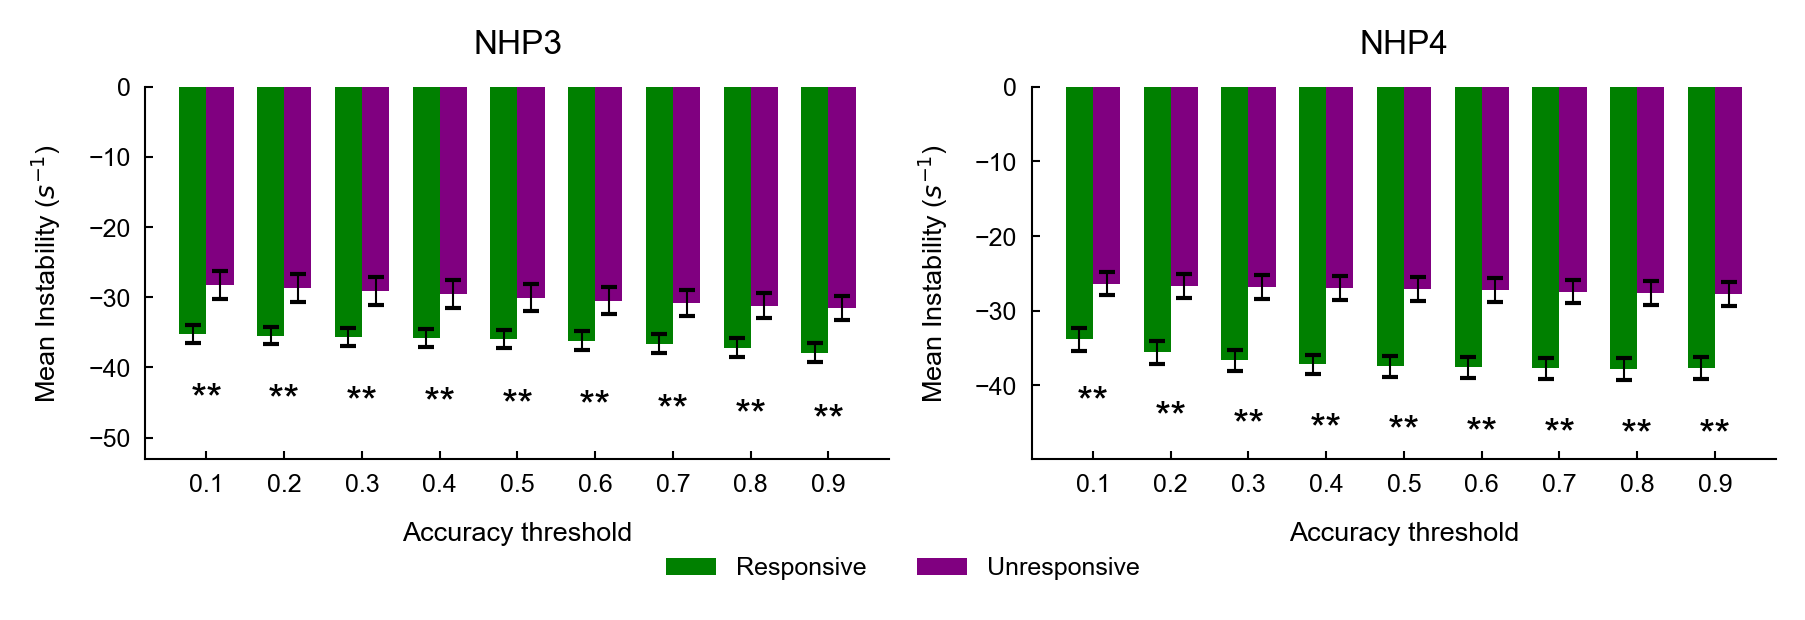

In [11]:
from scipy.stats import wilcoxon
import numpy as np
from matplotlib.patches import Patch

# Gather all data for bar plots
colors = ['green', 'purple']
bar_width = 0.35
x = np.arange(len(pct_correct_thresh_options))  # one position per threshold

fig, axs = plt.subplots(1, 2, figsize=(6, 2))

for i, monkey in enumerate(['SPOCK', 'PEDRI']):
    # Aggregate data for each monkey
    mean_awake, sem_awake = [], []
    mean_uncon, sem_uncon = [], []
    ps = []
    for pct_correct_thresh in pct_correct_thresh_options:
        awake_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['awake_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
        unconscious_stab_means_all = [single_session_tracking_data[pct_correct_thresh][monkey][session]['unconscious_stab_means'] for session in single_session_tracking_data[pct_correct_thresh][monkey]]
        mean_awake.append(np.mean(awake_stab_means_all))
        mean_uncon.append(np.mean(unconscious_stab_means_all))
        sem_awake.append(np.std(awake_stab_means_all, ddof=1)/np.sqrt(len(awake_stab_means_all)))
        sem_uncon.append(np.std(unconscious_stab_means_all, ddof=1)/np.sqrt(len(unconscious_stab_means_all)))
        # Perform Wilcoxon signed-rank test
        stat, p = wilcoxon(awake_stab_means_all, unconscious_stab_means_all, alternative='less')
        ps.append(p)
        print(f"monkey: {monkey}, pct_correct_thresh: {pct_correct_thresh}, p: {p}")

    ax = axs[i]
    # Bar positions
    bar1_x = x - bar_width/2
    bar2_x = x + bar_width/2

    bars1 = ax.bar(bar1_x, mean_awake, width=bar_width, label='Responsive', color=colors[0], yerr=sem_awake, capsize=2)
    bars2 = ax.bar(bar2_x, mean_uncon, width=bar_width, label='Unresponsive', color=colors[1], yerr=sem_uncon, capsize=2)

    # Calculate the bottom whisker locations for both bars
    bar1_bottoms = np.array(mean_awake) - np.array(sem_awake)
    bar2_bottoms = np.array(mean_uncon) - np.array(sem_uncon)
    # Associated positions for bar1 and bar2
    for idx, (xx, p) in enumerate(zip(x, ps)):
        # Calculate significance stars
        if p < 0.001:
            stars = '***'
        elif p < 0.01:
            stars = '**'
        elif p < 0.05:
            stars = '*'
        else:
            stars = 'ns'
        bar_xs = [bar1_x[idx], bar2_x[idx]]
        # Compute where the stars will sit, slightly below the lowest bar+errorbar
        min_bottom = min(bar1_bottoms[idx], bar2_bottoms[idx])
        # Offset below the bars
        offset_factor = 0.10 if monkey == 'SPOCK' else 0.08
        y_bar = min_bottom - offset_factor * abs(min_bottom)  # offset below
        tick_length = 0.05 * abs(min_bottom)
        # Put stars below
        text_obj = ax.text(np.mean(bar_xs), y_bar - tick_length, stars, ha='center', va='top', fontsize=10)

        # Adjust ylim if necessary so the lower stars/bracket are visible
        plt.draw()
        renderer = text_obj.figure.canvas.get_renderer()
        bbox = text_obj.get_window_extent(renderer=renderer)
        _, text_bottom_y = ax.transData.inverted().transform((bbox.x1, bbox.y0))  # y0 is the bottom of text bbox
        if text_bottom_y < ax.get_ylim()[0]:
            # Lower y limit to show stars and bracket
            ax.set_ylim(text_bottom_y - abs(offset_factor*min_bottom), ax.get_ylim()[1])

    ax.set_ylabel('Mean Instability ($s^{-1}$)')
    ax.set_xticks(x)
    ax.set_xticklabels([str(p) for p in pct_correct_thresh_options])
    ax.set_xlabel('Accuracy threshold')
    ax.set_title(f'NHP{i+3}')
    # ax.legend(loc="best")


# Add centered legend under the subplots
legend_handles = [
    Patch(facecolor=colors[0], label='Responsive'),
    Patch(facecolor=colors[1], label='Unresponsive')
]
fig.legend(handles=legend_handles, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.0))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(img_save_dir, 'supp', 'single-session-tracking-means-by-pct-correct.pdf'), transparent=True, bbox_inches='tight')
plt.show()
